# Counting Rings in Cropped Images - Real Data


Mod of [Zach Muller's WWF 01_Custom.ipynb](https://walkwithfastai.com/Custom).

Here we'll take cropped images of antinodes and try to count the rings.

In [ ]:
#all_slow

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage mrspuff typing_extensions -q --upgrade

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [ ]:
import espiownage
from espiownage.core import *
sysinfo()
print(f"espiownage version {espiownage.__version__}")

TORCH_VERSION=torch1.9.0; CUDA_VERSION=cu111
CUDA available = True, Device count = 1, Current device = 0
Device name = GeForce RTX 3080
hostname: bengio
espiownage version 0.0.44


And import our libraries

In [ ]:
from fastai.vision.all import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize, ResizeMethod
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

from mrspuff.utils import on_colab

In [ ]:
on_colab = on_colab()

if on_colab:
    path = untar_data('http://hedges.belmont.edu/~shawley/espiownage-cleaner.tgz') / 'crops'
else:
    path = Path('/home/shawley/datasets/espiownage-cleaner/crops') 

print(path)

/home/shawley/datasets/espiownage-cleaner/crops


In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
fnames[ind]

6614 total cropped images


Path('/home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_01083_156_232_247_339_1.8.png')

For labels, we want the ring count which is the number between the last '_' and the '.png'

In [ ]:
def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

1.8


In [ ]:
cropsize = (300,300) # pixels
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                    get_items=get_image_files,
                    splitter=RandomSplitter(),
                    get_y=label_func,
                    item_tfms=Resize(cropsize, ResizeMethod.Squish),
                    batch_tfms=[*aug_transforms(size=cropsize, flip_vert=True, max_rotate=360.0), 
                    Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = croppedrings.dataloaders(path, bs=32)

/home/shawley/.local/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


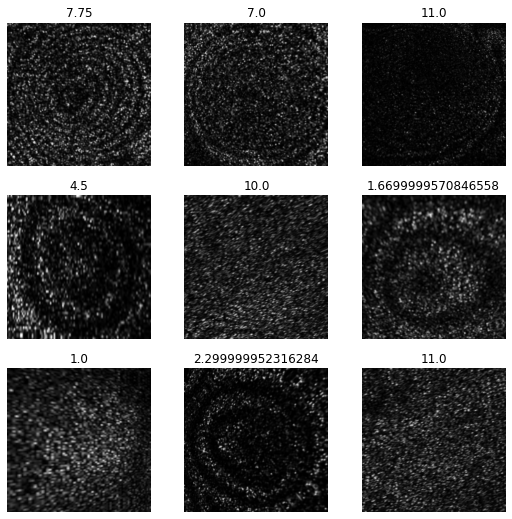

In [ ]:
dls.show_batch(max_n=9)

## Train model

In [ ]:
opt = ranger

In [ ]:
#PETS example learner:learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=MSELossFlat(), n_out=1, y_range=(0,11), opt_func=opt)#.to_fp16()

y_range=(0.2,13)  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlinearity
learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, 
                    metrics=[mae, acc_reg05, acc_reg07, acc_reg1,acc_reg15,acc_reg2], 
                    loss_func=MSELossFlat(), opt_func=opt)

/home/shawley/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.004365158267319202)

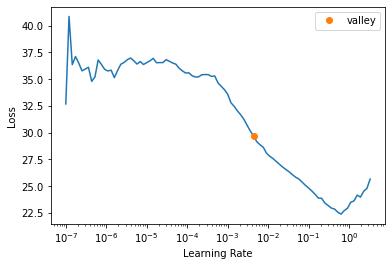

In [ ]:
learn.lr_find()

In [ ]:
#learn.fine_tune(10, 1e-2)
lr = 5e-3
learn.fine_tune(30, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg07,acc_reg1,acc_reg15,acc_reg2,time
0,12.572193,10.674751,2.496607,0.099849,0.167171,0.291225,0.392587,0.593797,00:17
1,8.401314,5.714202,1.826887,0.111952,0.204992,0.364599,0.504539,0.714826,00:17


epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg07,acc_reg1,acc_reg15,acc_reg2,time
0,5.305060,2.898077,1.228499,0.268533,0.385023,0.524206,0.693646,0.854766,00:21
1,4.258039,2.157441,1.010580,0.357035,0.484871,0.616490,0.795008,0.894100,00:21
2,3.082364,2.059832,0.942530,0.405446,0.528744,0.677761,0.831316,0.891074,00:21
3,2.647427,1.940982,0.883954,0.450832,0.563540,0.713313,0.836611,0.900908,00:21
4,2.450670,1.650340,0.863714,0.424357,0.568835,0.708018,0.845688,0.918306,00:21
5,2.294473,1.533333,0.759366,0.540847,0.651286,0.757942,0.869894,0.922088,00:21
6,2.259537,1.846673,0.885493,0.438729,0.599849,0.729955,0.845688,0.902421,00:21
7,2.034230,1.531544,0.757296,0.505295,0.651286,0.780635,0.878215,0.924357,00:21
8,2.252082,1.933859,0.853592,0.484115,0.584720,0.736006,0.844932,0.903177,00:21
9,1.977140,1.525645,0.742667,0.546142,0.685325,0.782905,0.875189,0.916793,00:21


In [ ]:
learn.save('crop-rings-real')

Path('models/crop-rings-real.pth')

## Interpretation

In [ ]:
learn.load('crop-rings-real');

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True) # validation set only
len(preds)

1322

I'll define a method to show a single prediction

In [ ]:
def showpred(ind, preds, targs, losses, dls): # show prediction at this index
    print(f"preds[{ind}] = {preds[ind]}, targs[{ind}] = {targs[ind]}, loss = {losses[ind]}")
    print(f"file = {dls.valid.items[ind]}")
    print("Image:")
    dls.valid.dataset[ind][0].show()

preds[0] = tensor([8.9587]), targs[0] = 11.0, loss = 4.166733741760254
file = /home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_01414_0_109_184_324_11.0.png
Image:


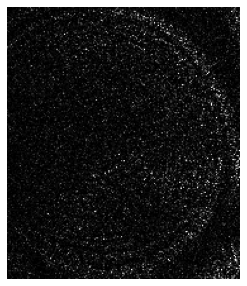

In [ ]:
showpred(0, preds, targs, losses, dls)

And now we'll run through predictions for the whole validation set:

In [ ]:
#preds, targs, losses = learn.get_preds(with_loss=True)
results = []
for i in range(len(preds)):
    line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy(), i]
    results.append(line_list)

# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'target', 'prediction', 'loss','i'])

We can do our own version of printing top_losses:

In [ ]:
res_df = res_df.sort_values('loss', ascending=False)
res_df.head()

,filename,target,prediction,loss,i
426,06241902_proc_00579_0_16_88_238_1.0,1.0,11.34,107.00977,426
1125,06241902_proc_01927_0_20_93_235_1.0,1.0,11.23,104.55182,1125
1051,06241902_proc_00381_0_59_81_228_1.0,1.0,10.73,94.67961,1051
651,06240907_proc_01542_0_101_178_318_1.0,1.0,9.67,75.11066,651
1311,06240907_proc_00322_0_114_195_323_2.2,2.2,9.45,52.56694,1311


preds[426] = tensor([11.3446]), targs[426] = 1.0, loss = 107.00977325439453
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00579_0_16_88_238_1.0.png
Image:
preds[1125] = tensor([11.2251]), targs[1125] = 1.0, loss = 104.55181884765625
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_01927_0_20_93_235_1.0.png
Image:
preds[1051] = tensor([10.7303]), targs[1051] = 1.0, loss = 94.67961120605469
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00381_0_59_81_228_1.0.png
Image:
preds[651] = tensor([9.6666]), targs[651] = 1.0, loss = 75.11065673828125
file = /home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_01542_0_101_178_318_1.0.png
Image:
preds[1311] = tensor([9.4503]), targs[1311] = 2.200000047683716, loss = 52.56694030761719
file = /home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_00322_0_114_195_323_2.2.png
Image:


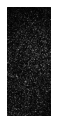

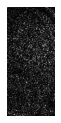

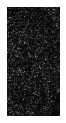

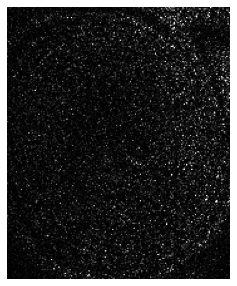

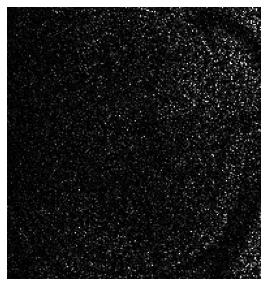

In [ ]:
def show_top_losses(res_df, preds, targs, losses, dls, n=5):
    for j in range(n):
        showpred(res_df.iloc[j]['i'], preds, targs, losses, dls)
        
show_top_losses(res_df, preds, targs, losses, dls)

So then we can these results output into a CSV file, and use it to direct our data-cleaning efforts, i.e. look at the top-loss images first! 

In [ ]:
res_df.to_csv('ring_count_top_losses_real.csv', index=False)

## When in doubt, look at the data...
Let's take a look at plots of this data

In [ ]:
df2 = res_df.reset_index(drop=True)

Text(0, 0.5, 'Ring count')

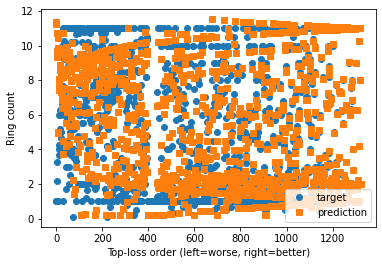

In [ ]:
plt.plot(df2["target"],'o',label='target')
plt.plot(df2["prediction"],'s', label='prediction')
plt.xlabel('Top-loss order (left=worse, right=better)')
plt.legend(loc='lower right')
plt.ylabel('Ring count')

(-0.44500000000000006, 12.007, -0.36600000000000005, 12.086)

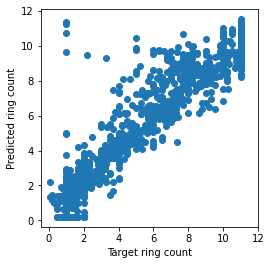

In [ ]:
plt.plot(df2["target"],df2["prediction"],'o')
plt.xlabel('Target ring count')
plt.ylabel('Predicted ring count')
plt.axis('square')

In [ ]:
print(f"Target ring count range: ({df2['target'].min()}, {df2['target'].max()})")
print(f"Predicted ring count range: ({df2['prediction'].min()}, {df2['prediction'].max()})")

Target ring count range: (0.1, 11.0)
Predicted ring count range: (0.2, 11.52)
